In [1]:
import glob              as gb
import matplotlib        as mp
import matplotlib.pyplot as plt
import numpy             as np
import numpy.ma          as nm
import pandas            as pd
import warnings          as ws

# Some figure options for later
mp.rcParams['xtick.labelsize'] = 14
mp.rcParams['ytick.labelsize'] = 14 

def compile_microcosm(options=None):
    # Function to help compile the microCOSM box model
    # Supply compile options as a list of the following:
    #    FIXATMPCO2 - disable the conservative atmospheric carbon box
    #    WRITEOUTFILE - enable the textfile output.
    # NOTE: you have to restart the kernal if you change these options and recompile
    #       more than once...limitation of using f2py
    import subprocess
    import os
    
    # Depending on platform
    if os.sys.platform == 'darwin':
        # Issue with compilation where f2py is linking to v10.9 rather than current OSX version.
        import platform
        mac_ver='.'.join(platform.mac_ver()[0].split('.')[:2])
        env=dict(os.environ,**{"MACOSX_DEPLOYMENT_TARGET":mac_ver})
    else:
        env=os.environ
    
    optdefs="OPTIONDEFS = "
    if options is not None:
        optdefs=optdefs+" ".join(['-D' + item for item in options])
        print('Compiling with options: '+optdefs)
    
    runmake=subprocess.Popen(["make","pymodel",optdefs],
                             stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE, 
                             text=True, 
                             env=env
                            )
    runmake.wait()
    print("The exit code for compilations was: %d" % runmake.returncode)
    return runmake.returncode

## 1. Model parameters and initial conditions

<img src="boxmodel_schematic.png" width="350" />

The _microCOSM_ model has three boxes linked by an overturning circulation: an cool, fresh, upwelling box with low iron input analagous to HNLC regions like the Southern Ocean, and a warmer, salty, deep water formation region with significant iron input analagous to the Atlantic Ocean. Iron-binding ligands are produced by organic matter turnover, and lost by microbial degradation (Lauderdale et al, 2020, doi:10.1073/pnas.1917277117).

First, we want to compile the model with the correct flags:

In [2]:
ec=compile_microcosm(options=["FIXATMPCO2"])

if ec==0:
    import microCOSM

Compiling with options: OPTIONDEFS = -DFIXATMPCO2
The exit code for compilations was: 0


Set a few parameters:

In [3]:
# Number of increments in parameter space
nincs=100

# Fixed value for uniform ligand control experiment
fixedligconc=1.0

# Do the analysis using nitrate (NP=16) or native phosphate (NP=1)
R_np=16
R_cp=106

# Convert mol/kg to mol/m3
conv = 1024.5 
         
# Total number of model runs in ensemble
niters=nincs*nincs

# Start counting the model runs at ninit
ninit =0

# Box dimensions (m)
dx=np.array([17.0e6, 17.0e6, 17.0e6]) 
dy=np.array([ 3e6,   13e6, 16.0e6]) 
dz=np.array([50.0,   50.0, 5050.0]) 

area = dx * dy 
vol= area * dz 
invol = 1.0 / vol

psi=20.0e6 # Sv

# Biological production maximum rate per year
alpha_yr=6e-6

# Deep ocean box lifetime modifier - capture the gradient introduced by photodegradation near the surface and slower loss in the deep ocean
dlambdadz=0.01

**Surface iron input rate (Atlantic receives 1.00xdep [g/m2/yr] while SO receives 0.01xdep)**

Default value in the model (7.0) is taken from the box model paper (Table 1) in Parekh et al (2004) with a asymetry value of 0.01. Data from Mahowald et al (2006) suggests:\
• Whole NA: 0.25 gFE m-2 yr-1\
• 0 to 20N: 0.40 gFE m-2 yr-1\
• 20N ++  : 0.16 gFE m-2 yr-1\
• 40N ++  : 0.10 gFE m-2 yr-1\
• Whole SO: 0.0015 gFE m-2 yr-1\
• Whole SH: 0.0033 gFE m-2 yr-1


In [4]:
# Dust deposition in g Fe m-2 year-1
dustdep=0.15
# Hydrothermal vent input of 1 Gmol/yr (Tagliabue et al., 2010)
# mol Fe/yr * g/mol * 1/area  == g Fe m-2 year-1....
# divide by 2.5e-3 because fe_sol=2.5e-3 is multiplied again within the box model.
ventdep=(1e9*56)/(area[2]*0.0025)

# Gamma over lambda for ligands "optimum" value (Lauderdale et al 2020)
lig_gaovla = 4398.

# gamma input to the model is in phosphate units, not carbon units... 
# (also applies to gamma_over_lambda...lambda should be in 1/seconds)
lig_gamma  = (5e-5*R_cp)
lig_lambda = 1./((lig_gamma/R_cp)/lig_gaovla)

# Because f2py is finicky about allocatable output arrays, it is ideal to aim for 1000 output timesteps
# Run for 100kyrs, with 100 year output
maxyears   = 1e5
outputyears= 1e2

# Typical concentrations, etc
theta = np.array(( 2.0,  20.0,   4.0 ))
salt  = np.array((34.00, 35.50, 34.75))

SPUNUP=False

if SPUNUP is True:
    # Here are some equilibrated initial concentrations in mol/kg 
    # run for 100,000 yrs (round-off error notwithstanding)
    # Make sure to compile without -DFIXATMPCO2
    carbon     = np.array((2264.67564, 2103.48757, 2364.66971))*1.0e-6
    alkalinity = np.array((2395.54471, 2387.42965, 2399.11941))*1.0e-6
    phosphate  = np.array((   1.81089,    0.25031,    2.49834))*1.0e-6
    nitrate    = np.array((  25.01353,    0.04412,   36.01262))*1.0e-6
    iron       = np.array((   0.00377,    0.49776,    0.58847))*1.0e-9
    ligand     = np.array((   2.08548,    1.56387,    1.62029))*1.0e-9
    atmpco2    = np.array((280.00000,))
else:
   # Here are some typical initial concentrations in mol/kg
   # Make sure to compile with -DFIXATMPCO2 first
    carbon     = np.array((2100.0, 2100.0, 2350.0))*1.0e-6
    alkalinity = np.array((2300.0, 2300.0, 2400.0))*1.0e-6
    phosphate  = np.array((   2.0,    0.0,    2.5))*1.0e-6
    nitrate    = np.array((  32.0,    0.0,   36.0))*1.0e-6
    iron       = np.array((   0.0,    0.0,    0.0))*1.0e-9 
    ligand     = np.array((   0.0,    0.0,    0.0))*1.0e-9 
    atmpco2    = np.array((280.00000,))

### Create a consolidated Pandas dataframe with the input values to feed into the model

In [5]:
time=pd.DataFrame(data=np.array([[maxyears,outputyears]]),index=[0],
                              columns=["nyrs","tout"])

data=pd.DataFrame(data=np.concatenate((theta,
                                       salt,
                                       carbon,
                                       alkalinity,
                                       phosphate,
                                       nitrate,
                                       iron,
                                       ligand,
                                       atmpco2))[np.newaxis,:],index=[0],
                              columns=["tso","tna","tdo",
                                      "sso","sna","sdo",
                                      "cso","cna","cdo",
                                      "aso","ana","ado",
                                      "pso","pna","pdo",
                                      "nso","nna","ndo",
                                      "fso","fna","fdo",
                                      "lso","lna","ldo",
                                      "atmpco2"])

parm=pd.DataFrame(data=np.array([[lig_gamma,
                                  lig_lambda,
                                  dustdep, 
                                  ventdep, 
                                  alpha_yr,
                                  dlambdadz, 
                                  psi,
                                  1.0]]), index=[0],
                              columns=["gamma",
                                       "lambda",
                                       "sFetop",
                                       "sFebot",
                                       "alphabio",
                                       "dlambdadz",
                                       "psi",
                                       "niter"])

model_input=pd.concat((time,data,parm),axis=1)
model_input

,nyrs,tout,tso,tna,tdo,sso,sna,sdo,cso,cna,...,ldo,atmpco2,gamma,lambda,sFetop,sFebot,alphabio,dlambdadz,psi,niter
0,100000.0,100.0,2.0,20.0,4.0,34.0,35.5,34.75,0.0021,0.0021,...,0.0,280.0,0.0053,87960000.0,0.15,0.082353,0.000006,0.01,20000000.0,1.0


### Call the model from the _microCOSM_ package and capture the output in a pandas dataframe 

In [6]:
timeseries = pd.DataFrame(
                    microCOSM.mod_modelmain.model(*[model_input[io].values for io in model_input.columns]),
                                     index=["time",
                                            "tso","tna","tdo",
                                            "sso","sna","sdo",
                                            "cso","cna","cdo",
                                            "aso","ana","ado",
                                            "pso","pna","pdo",
                                            "nso","nna","ndo",
                                            "fso","fna","fdo",
                                            "lso","lna","ldo",
                                            "export1","export2",
                                            "lim","pstar",
                                            "spco2","npco2","atmpco2"]).transpose()

# output array such that it could be used to restart the next simulation
pd.concat([time.iloc[0],
           timeseries.iloc[-1].drop(["time","export1","export2","lim","pstar","spco2","npco2"]),
           parm.iloc[0]]).to_frame().transpose().to_json("run_microCOSM_pickup.json")

## 2. Plot the model timeseries

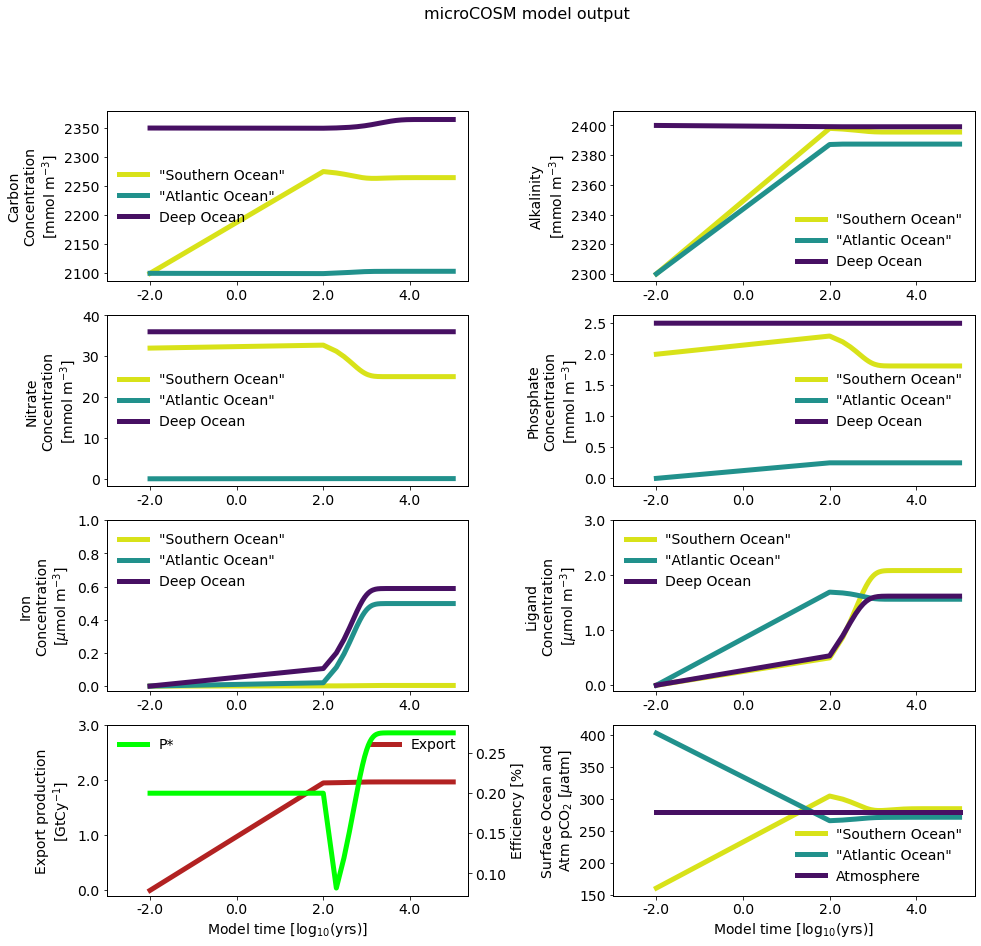

In [7]:
# Make sure initial conditions are included at t~0
timeseries.at[0, 'time'] = 1e-2

# Integrated export production
timeseries["exp"]=(timeseries["export1"]+timeseries["export2"])*R_cp*86400*365*12*1e-15 # convert molP/s to GtC/yr

#Plot the timeseries of...
from matplotlib.ticker     import FormatStrFormatter

len_xaxis,len_yaxis = 4,4 #fix here your numbers
xspace, yspace = .9, .9 # change the size of the void border here.
x_fig,y_fig = len_xaxis / xspace, len_yaxis / yspace

f1, f1ax = plt.subplots(figsize=(3.5*x_fig, 3.25*y_fig),ncols=2,nrows=4)
f1.patch.set_facecolor('None')
mycm = plt.cm.get_cmap("viridis")

# ...Carbon and Alkalinity
## SO
f1ax[0,0].plot(np.log10(timeseries["time"]),timeseries["cso"],
           color=mycm(240),linewidth=5,label="\"Southern Ocean\"")
# AO
f1ax[0,0].plot(np.log10(timeseries["time"]),timeseries["cna"],
           color=mycm(128),linewidth=5,label="\"Atlantic Ocean\"")
# DO
f1ax[0,0].plot(np.log10(timeseries["time"]),timeseries["cdo"],
           color=mycm(10),linewidth=5,label="Deep Ocean")

f1ax[0,0].legend(frameon=False,fontsize=14)
f1ax[0,0].set_ylim(top=np.ceil(np.max(f1ax[0,0].get_ylim())/10)*10)
f1ax[0,0].set_xlim(left=-3)
f1ax[0,0].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f1ax[0,0].set_ylabel("Carbon\nConcentration\n[mmol m$^{-3}$]",fontsize=14)

## SO
f1ax[0,1].plot(np.log10(timeseries["time"]),timeseries["aso"],
           color=mycm(240),linewidth=5,label="\"Southern Ocean\"")
# AO
f1ax[0,1].plot(np.log10(timeseries["time"]),timeseries["ana"],
           color=mycm(128),linewidth=5,label="\"Atlantic Ocean\"")
# DO
f1ax[0,1].plot(np.log10(timeseries["time"]),timeseries["ado"],
           color=mycm(10),linewidth=5,label="Deep Ocean")
f1ax[0,1].legend(frameon=False,fontsize=14)
f1ax[0,1].set_ylim(top=np.ceil(np.max(f1ax[0,1].get_ylim())/10)*10)
f1ax[0,1].set_xlim(left=-3)
f1ax[0,1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f1ax[0,1].set_ylabel("Alkalinity\n[mmol m$^{-3}$]",fontsize=14)

# ...Macronutrients
# SO
f1ax[1,0].plot(np.log10(timeseries["time"]),timeseries["nso"],
            color=mycm(240),linewidth=5,label="\"Southern Ocean\"")
# AO 
f1ax[1,0].plot(np.log10(timeseries["time"]),timeseries["nna"],
            color=mycm(128),linewidth=5,label="\"Atlantic Ocean\"")
# DO
f1ax[1,0].plot(np.log10(timeseries["time"]),timeseries["ndo"],
            color=mycm(10),linewidth=5,label="Deep Ocean")
f1ax[1,0].set_ylim(top=np.ceil(np.max(f1ax[1,0].get_ylim())/10)*10)
f1ax[1,0].legend(frameon=False,fontsize=14)
f1ax[1,0].set_xlim(left=-3)
f1ax[1,0].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f1ax[1,0].set_ylabel("Nitrate\nConcentration\n[mmol m$^{-3}$]",fontsize=14)

# SO
f1ax[1,1].plot(np.log10(timeseries["time"]),timeseries["pso"],
            color=mycm(240),linewidth=5,label="\"Southern Ocean\"")
# AO 
f1ax[1,1].plot(np.log10(timeseries["time"]),timeseries["pna"],
            color=mycm(128),linewidth=5,label="\"Atlantic Ocean\"")
# DO
f1ax[1,1].plot(np.log10(timeseries["time"]),timeseries["pdo"],
            color=mycm(10),linewidth=5,label="Deep Ocean")
f1ax[1,1].legend(frameon=False,fontsize=14)
#f1ax2.set_ylim(top=3)
f1ax[1,1].set_xlim(left=-3)
f1ax[1,1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f1ax[1,1].set_ylabel("Phosphate\nConcentration\n[mmol m$^{-3}$]",fontsize=14)

# ...Iron/Ligands
# SO
f1ax[2,0].plot(np.log10(timeseries["time"]),timeseries["fso"],
            color=mycm(240),linewidth=5,label="\"Southern Ocean\"")
# AO
f1ax[2,0].plot(np.log10(timeseries["time"]),timeseries["fna"],
            color=mycm(128),linewidth=5,label="\"Atlantic Ocean\"")
# DO
f1ax[2,0].plot(np.log10(timeseries["time"]),timeseries["fdo"],
            color=mycm(10),linewidth=5,label="Deep Ocean")
f1ax[2,0].legend(frameon=False,fontsize=14)
f1ax[2,0].set_ylim(top=np.ceil(np.max(f1ax[2,0].get_ylim())))
f1ax[2,0].set_xlim(left=-3)
f1ax[2,0].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f1ax[2,0].set_ylabel("Iron\nConcentration\n[$\mu$mol m$^{-3}$]",fontsize=14)

# SO
f1ax[2,1].plot(np.log10(timeseries["time"]),timeseries["lso"],
            color=mycm(240),linewidth=5,label="\"Southern Ocean\"")
# AO
f1ax[2,1].plot(np.log10(timeseries["time"]),timeseries["lna"],
            color=mycm(128),linewidth=5,label="\"Atlantic Ocean\"")
# DO
f1ax[2,1].plot(np.log10(timeseries["time"]),timeseries["ldo"],
            color=mycm(10),linewidth=5,label="Deep Ocean")
f1ax[2,1].legend(frameon=False,fontsize=14)
f1ax[2,1].set_ylim(top=np.ceil(np.max(f1ax[2,1].get_ylim())))
f1ax[2,1].set_xlim(left=-3)
f1ax[2,1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f1ax[2,1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f1ax[2,1].set_ylabel("Ligand\nConcentration\n[$\mu$mol m$^{-3}$]",fontsize=14)

#...Export/pstar
# Total
f1ax[3,0].plot(np.log10(timeseries["time"]),timeseries["exp"],
            color='firebrick',linewidth=5,label="Export")
# PS
f1ax30b=f1ax[3,0].twinx()
f1ax30b.plot(np.log10(timeseries["time"]),timeseries["pstar"],
            color='lime',linewidth=5,label="P*")
f1ax[3,0].legend(frameon=False,fontsize=14)
f1ax30b.legend(frameon=False,fontsize=14)
f1ax[3,0].set_ylim(top=np.ceil(np.max(f1ax[3,0].get_ylim())))
f1ax[3,0].set_xlim(left=-3)
f1ax[3,0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f1ax[3,0].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f1ax[3,0].set_ylabel("Export production\n[GtCy$^{-1}$]",fontsize=14)
f1ax30b.set_ylabel("Efficiency [%]",fontsize=14)
f1ax[3,0].set_xlabel("Model time [log$_{10}$(yrs)]",fontsize=14)

# ...pCO2
# SO
f1ax[3,1].plot(np.log10(timeseries["time"]),timeseries["spco2"],
            color=mycm(240),linewidth=5,label="\"Southern Ocean\"")
# AO
f1ax[3,1].plot(np.log10(timeseries["time"]),timeseries["npco2"],
            color=mycm(128),linewidth=5,label="\"Atlantic Ocean\"")
# ATM
f1ax[3,1].plot(np.log10(timeseries["time"]),timeseries["atmpco2"],
            color=mycm(10),linewidth=5,label="Atmosphere")
f1ax[3,1].legend(frameon=False,fontsize=14)
f1ax[3,1].set_ylim(top=np.ceil(np.max(f1ax[3,1].get_ylim())))
f1ax[3,1].set_xlim(left=-3)
f1ax[3,1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f1ax[3,1].set_ylabel("Surface Ocean and\nAtm pCO$_2$ [$\mu$atm]",fontsize=14)
f1ax[3,1].set_xlabel("Model time [log$_{10}$(yrs)]",fontsize=14)

plt.suptitle("microCOSM model output",fontsize=16)
# Can adjust the subplot size
plt.subplots_adjust(wspace=0.4)
plt.show()  

## 3. Profit???
It's possible to use _microCOSM_ to perform efficient ensemble/parameter space exploration (potentially in parallel using the "Pandarallel" package's "parallel_apply" function). You cannot 'reload' _f2py_ extension modules, so see the "run_microCOSM_ensemble" notebook in this repository for a brief "how to".